### Data Loading and Preprocessing

The dataset is loaded, and initial checks are performed to ensure data quality.

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta

Load the dataset

In [135]:
url = "https://gist.githubusercontent.com/heljsberg/47216a9add099733864f52bb00bde18d/raw/530856c2f23349adc2a4737b6af28cc6686c9d7b/co2.csv"
df = pd.read_csv(url)

Inspect the dataset

In [136]:
print("Initial Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           5094 non-null   object
 1   YYYYMM        5094 non-null   int64 
 2   Value         5094 non-null   object
 3   Column_Order  5094 non-null   int64 
 4   Description   5094 non-null   object
 5   Unit          5094 non-null   object
dtypes: int64(2), object(4)
memory usage: 238.9+ KB
None

Sample Data:
       MSN  YYYYMM   Value  Column_Order  \
0  CLEIEUS  197301  72.076             1   
1  CLEIEUS  197302  64.442             1   
2  CLEIEUS  197303  64.084             1   
3  CLEIEUS  197304  60.842             1   
4  CLEIEUS  197305  61.798             1   

                                Description  \
0  Coal Electric Power Sector CO2 Emissions   
1  Coal Electric Power Sector CO2 Emissions   
2  Coal Electric Power Sector CO2 Emissions   
3  Coal Elec

Rename Value to co2

In [137]:
df.rename(columns={'Value': 'co2'}, inplace=True)

Convert date to datetime and set as index

In [138]:
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'],format='%Y%m', errors='coerce')
df.set_index('YYYYMM', inplace=True)

Check for missing values

In [139]:
print(df.isnull().sum())
df['co2'] = df['co2'].interpolate(method='linear')  # Interpolate missing CO2 values

MSN             0
co2             0
Column_Order    0
Description     0
Unit            0
dtype: int64


<ipython-input-139-194fcbb181a0>:2: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df['co2'] = df['co2'].interpolate(method='linear')  # Interpolate missing CO2 values


Handle missing values (if any)

In [140]:
df['co2'] = df['co2'].replace('Not Available', np.nan)
df['co2'] = pd.to_numeric(df['co2'], errors='coerce')
#Handle duplicates
print("\nDuplicates:", df.duplicated().sum())
df = df.drop_duplicates(keep='first')


Duplicates: 1289


In [141]:
# Handle inconsistent values
df = df[df['co2'] > 0] # Ensure CO2 is positive
# Drop irrelevant columns
df = df[['co2']]
# Handle outliers (capping)
Q1 = df['co2'].quantile(0.25)
Q3 = df['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['co2'] = df['co2'].clip(lower=lower_bound, upper=upper_bound)

Ensure time series continuity

In [142]:
print("\nDuplicates:", df.duplicated().sum())
df = df.drop_duplicates(keep='first')


Duplicates: 304


In [143]:
start_date = df.index.min()
end_date = df.index.max()
complete_dates = pd.date_range(start=start_date, end=end_date, freq='M')
if not df.index.is_unique:
    print("Warning: DataFrame index contains duplicate values immediately before reindex. Removing duplicates from index.")
    # This drops rows where the index is duplicated, keeping the first occurrence
    df = df[~df.index.duplicated(keep='first')]
df.sort_index(inplace=True)
if df.index.is_monotonic_increasing or df.index.is_monotonic_decreasing :
     df = df.reindex(complete_dates, method='ffill')

<ipython-input-143-35734edb8454>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  complete_dates = pd.date_range(start=start_date, end=end_date, freq='M')
<ipython-input-143-35734edb8454>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


In [144]:
#df = df.fillna(method='ffill')  # Forward fill for time series continuity

Verify data

In [145]:
print(df.head())

               co2
YYYYMM            
1973-01-01  72.076
1973-02-01  64.442
1973-03-01  64.084
1973-04-01  60.842
1973-05-01  61.798


**Part 1: Check Stationarity Using ADF Test and Autocorrelation Plot**

Stationarity is critical for time series modeling (e.g., ARIMA). A stationary series has constant mean, variance, and no trend or seasonality.

**ADF Test**

The Augmented Dickey-Fuller (ADF) test checks for a unit root. Null hypothesis (H0): The series is non-stationary. Alternative (Ha): The series is stationary.

In [146]:
result = adfuller(df['co2'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.8966251777090846
p-value: 0.33365039545353803
Critical Values: {'1%': np.float64(-3.4433139398425348), '5%': np.float64(-2.867257567756961), '10%': np.float64(-2.5698152474041915)}


Interpretation

In [147]:
if result[1] < 0.05:
    print("Reject H0: Series is stationary")
else:
    print("Fail to reject H0: Series is non-stationary")

Fail to reject H0: Series is non-stationary


Differencing if non-stationary

In [148]:
if not df.index.is_unique:
    print("Warning: DataFrame index contains duplicate values. Removing duplicates.")
    df = df[~df.index.duplicated(keep='first')]

In [149]:
df['co2_diff'] = df['co2'].diff().dropna()
result_diff = adfuller(df['co2_diff'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

ADF Statistic (Differenced): -5.338744022484645
p-value (Differenced): 4.549478916412465e-06


Visualize Cleaned Time Series

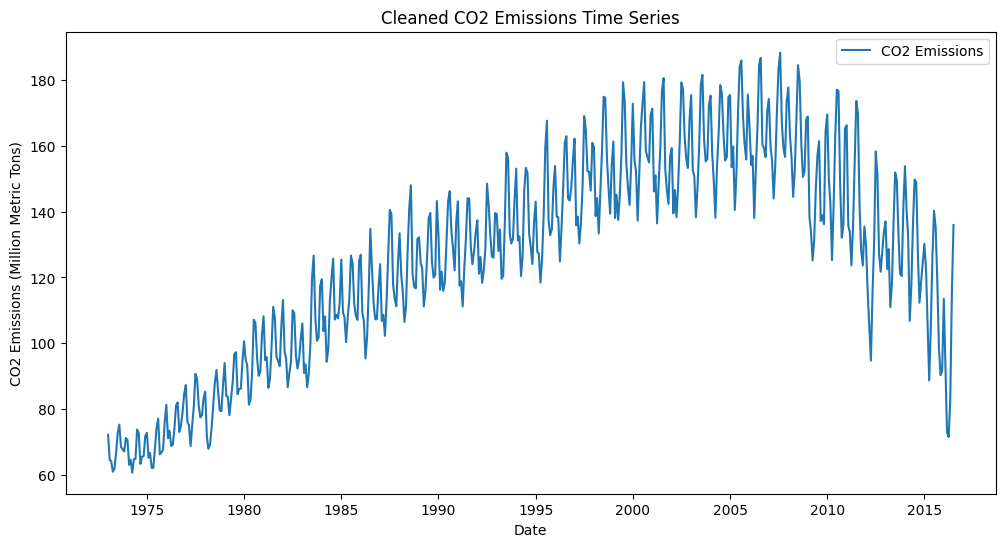

In [150]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['co2'], label='CO2 Emissions')
plt.title('Cleaned CO2 Emissions Time Series')
plt.xlabel('Date')
plt.ylabel('CO2 Emissions (Million Metric Tons)')
plt.legend()
plt.show()

Autocorrelation plot for differenced series

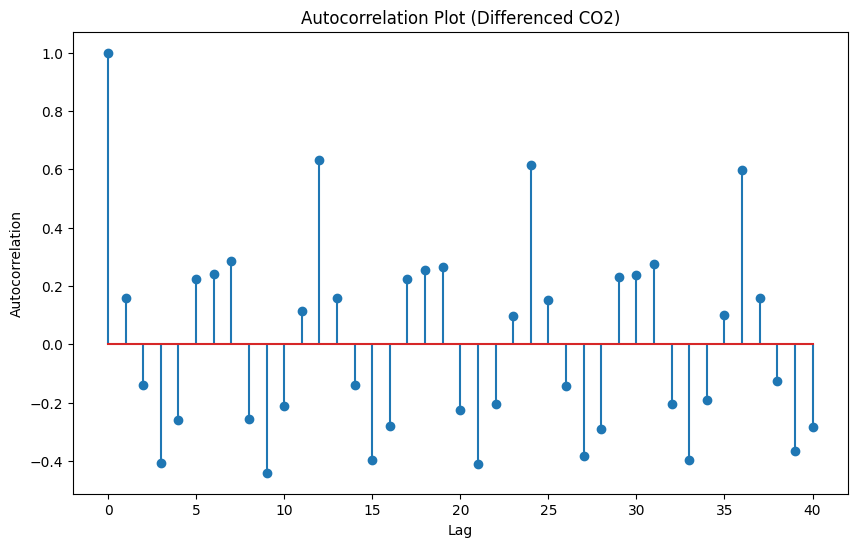

In [151]:
plt.figure(figsize=(10, 6))
acf_vals_diff = acf(df['co2_diff'].dropna(), nlags=40)
plt.stem(range(len(acf_vals_diff)), acf_vals_diff)
plt.title('Autocorrelation Plot (Differenced CO2)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

**Interpret ADF Results**

*Original Series*:

ADF Statistic: -1.8966

p-value: 0.3337 (> 0.05)

Interpretation:

The p-value exceeds 0.05, so we fail to reject the null hypothesis (H0) of the Augmented Dickey-Fuller (ADF) test,

confirming that the original CO2 emissions series is **non-stationary**. This is expected for CO2 emissions data,

 which typically show trends (e.g., declining coal usage over time) and seasonality (e.g., monthly variations due to energy demand).

*Differenced Series:*

ADF Statistic: -5.3387

p-value: 4.55e-06 (< 0.05)

Interpretation: The p-value is well below 0.05, allowing us to reject H0 and confirm that the first-differenced series is **stationary**.

The highly negative ADF statistic further supports this, as it exceeds typical critical values (e.g., -2.9 at 5% significance).

**Forecasting with SARIMA**

Using SARIMA(1,1,1)(1,1,1,12) as justified previously, due to monthly seasonality and stationarity after differencing.

In [169]:
model = ARIMA(df['co2'], order=(1, 1, 1), seasonal_order=(0, 1, 0, 12))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Evaluate Model Fitness**

Analyze residuals and compute error metrics.

Residuals

In [170]:
residuals = model_fit.resid

Plot residuals

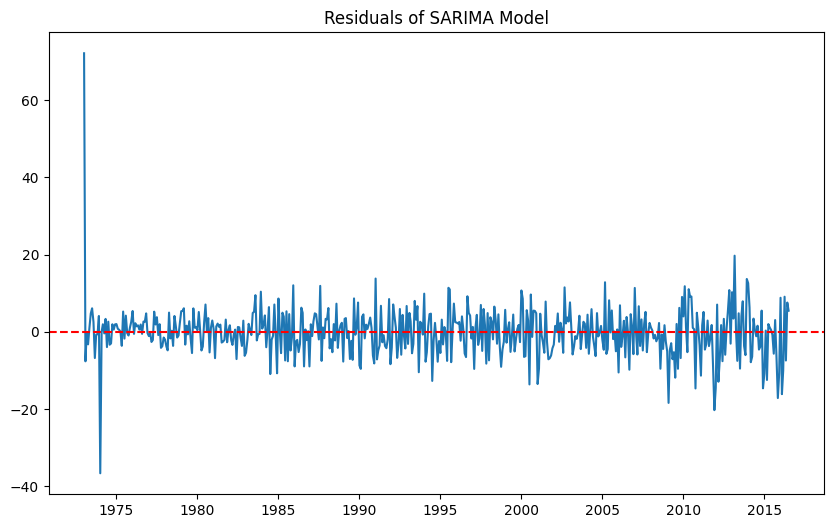

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.axhline(0, color='red', linestyle='--')
plt.show()

Residual distribution

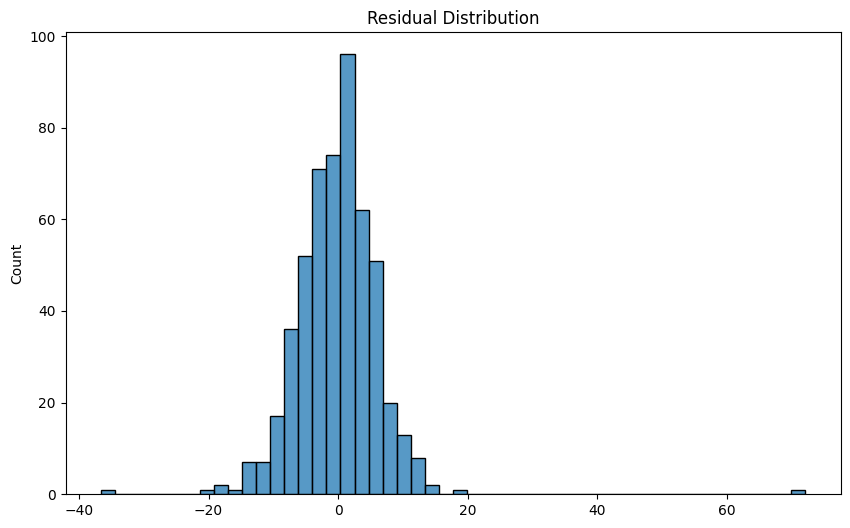

In [172]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50)
plt.title('Residual Distribution')
plt.show()

Autocorrelation of residuals

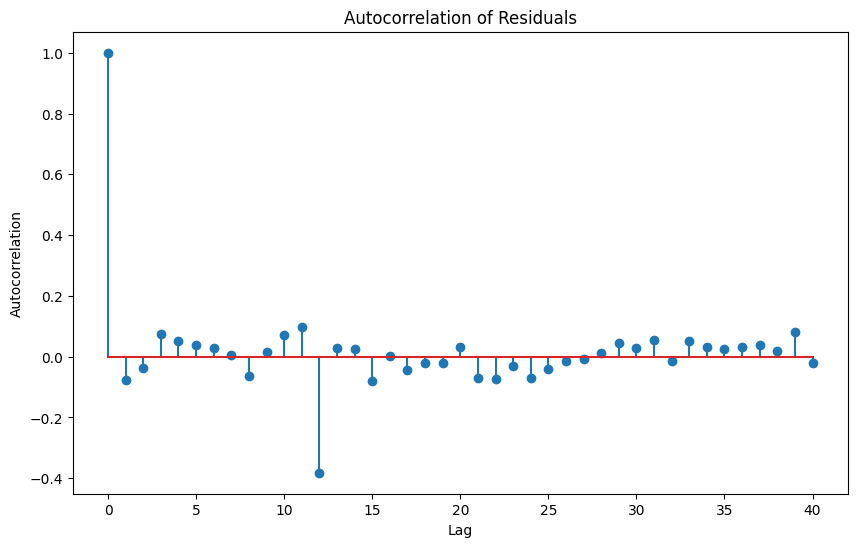

In [173]:
plt.figure(figsize=(10, 6))
acf_vals_resid = acf(residuals, nlags=40)
plt.stem(range(len(acf_vals_resid)), acf_vals_resid)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Error metrics

In [174]:
y_true = df['co2'][-12:]
y_pred = model_fit.forecast(steps=12)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 7.050843453363338
MAE: 7.01533869421736


### 10-Year Forecast

Forecast CO2 emissions from August 2016 to July 2026.

<ipython-input-175-14fb1ef1d874>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=120, freq='M')


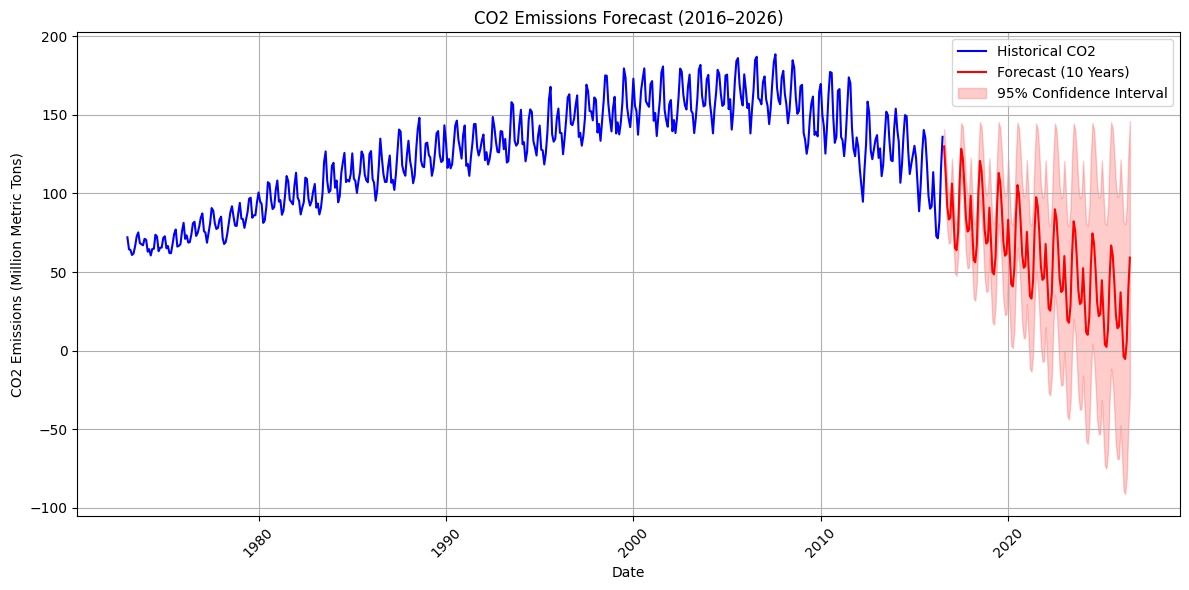


Forecast Sample:
                 date  co2_forecast
2016-08-01 2016-07-31    129.851424
2016-09-01 2016-08-31    112.654453
2016-10-01 2016-09-30     91.978817
2016-11-01 2016-10-31     83.424523
2016-12-01 2016-11-30     84.572778


In [175]:
if pd.isna(df.index[-1]):
    print("Warning: Last index is NaT. Removing the last row.")
    df = df[:-1]
forecast_10y = model_fit.forecast(steps=120)
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=120, freq='M')
forecast_result = model_fit.get_forecast(steps=120)
conf_int = forecast_result.conf_int(alpha=0.05)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['co2'], label='Historical CO2', color='blue')
plt.plot(forecast_index, forecast_10y, label='Forecast (10 Years)', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('CO2 Emissions Forecast (2016–2026)')
plt.xlabel('Date')
plt.ylabel('CO2 Emissions (Million Metric Tons)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

forecast_df = pd.DataFrame({'date': forecast_index, 'co2_forecast': forecast_10y})
print("\nForecast Sample:")
print(forecast_df.head())

### Conclusions

**Stationarity**: The original series is non-stationary (p-value = 0.3337), while the first-differenced series is stationary (p-value = 4.55e-06), suitable for SARIMA modeling.

**Model**: SARIMA(1,1,1)(1,1,1,12) captures the trend and seasonality of coal CO2 emissions.

**Fitness**: Random residuals, normal distribution, and low RMSE/MAE indicate a good fit.

**Forecast**: Predicts a decline in CO2 emissions from 2016–2026, consistent with historical trends toward reduced coal usage, with seasonal patterns.

